In [1]:
import numpy as np
import pandas as pd
from pytorch_forecasting import TimeSeriesDataSet
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from pytorch_forecasting.data import MultiNormalizer,GroupNormalizer
import matplotlib.pyplot as plt
import seaborn as sns
import torch

/Users/msughter/anaconda3/envs/poolenv/lib/python3.10/site-packages/threadpoolctl.py:1214: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/Users/msughter/anaconda3/envs/poolenv/lib/python3.10/site-packages/pytorch_forecasting/models/base_model.py:30: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm


In [2]:
pool_data = pd.read_csv('PoolData.csv',on_bad_lines='skip')
# take a look at the data
pool_data.head()

,date,volumeUSDChange,volumeToken0Change,volumeToken1Change,tvlUSDChange,txCount,feesUSD
0,1708041600,-1.134062e+08,-1.134397e+08,-40444.288855,-1.340651e+06,6112,71218.096220
1,1708128000,-2.021456e+07,-2.022691e+07,-6543.765972,2.032085e+06,5318,61110.814054
2,1708214400,1.004206e+07,1.007014e+07,2807.137887,3.506131e+06,5947,66131.846264
3,1708300800,1.042544e+08,1.042212e+08,34278.399880,1.366455e+06,6827,118259.065975
4,1708387200,3.163059e+07,3.164884e+07,9927.220991,5.582752e+06,7136,134074.363181


In [3]:
# get more statistical information about the data
pool_data.describe()

,date,volumeUSDChange,volumeToken0Change,volumeToken1Change,tvlUSDChange,txCount,feesUSD
count,9.900000e+02,9.900000e+02,9.900000e+02,9.900000e+02,9.900000e+02,990.000000,9.900000e+02
mean,1.712275e+09,4.886174e+05,3.172368e+05,1.098578e+05,3.886413e+05,1698.201010,6.078784e+04
std,2.470334e+06,7.328615e+07,6.627237e+07,2.944746e+07,1.031125e+07,2326.680401,9.994701e+04
min,1.708042e+09,-7.469638e+08,-7.463939e+08,-3.500031e+08,-8.136680e+07,6.000000,3.321232e+00
25%,1.710115e+09,-1.179282e+07,-1.906429e+06,-2.686228e+05,-1.062848e+06,248.250000,3.824943e+03
50%,1.712275e+09,-2.034204e+05,-4.715822e+01,-3.309524e+02,1.211091e+03,745.500000,2.861033e+04
75%,1.714435e+09,1.202061e+07,7.393220e+05,3.479959e+04,1.546306e+06,1385.750000,8.214568e+04
max,1.716509e+09,7.683531e+08,7.676765e+08,2.720772e+08,9.420977e+07,10561.000000,1.781509e+06


In [4]:
# convert the date time from seconds
pool_data['date'] = pd.to_datetime(pool_data.date, unit='s')

/Users/msughter/anaconda3/envs/poolenv/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/msughter/anaconda3/envs/poolenv/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/msughter/anaconda3/envs/poolenv/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/msughter/anaconda3/envs/poolenv/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na opti

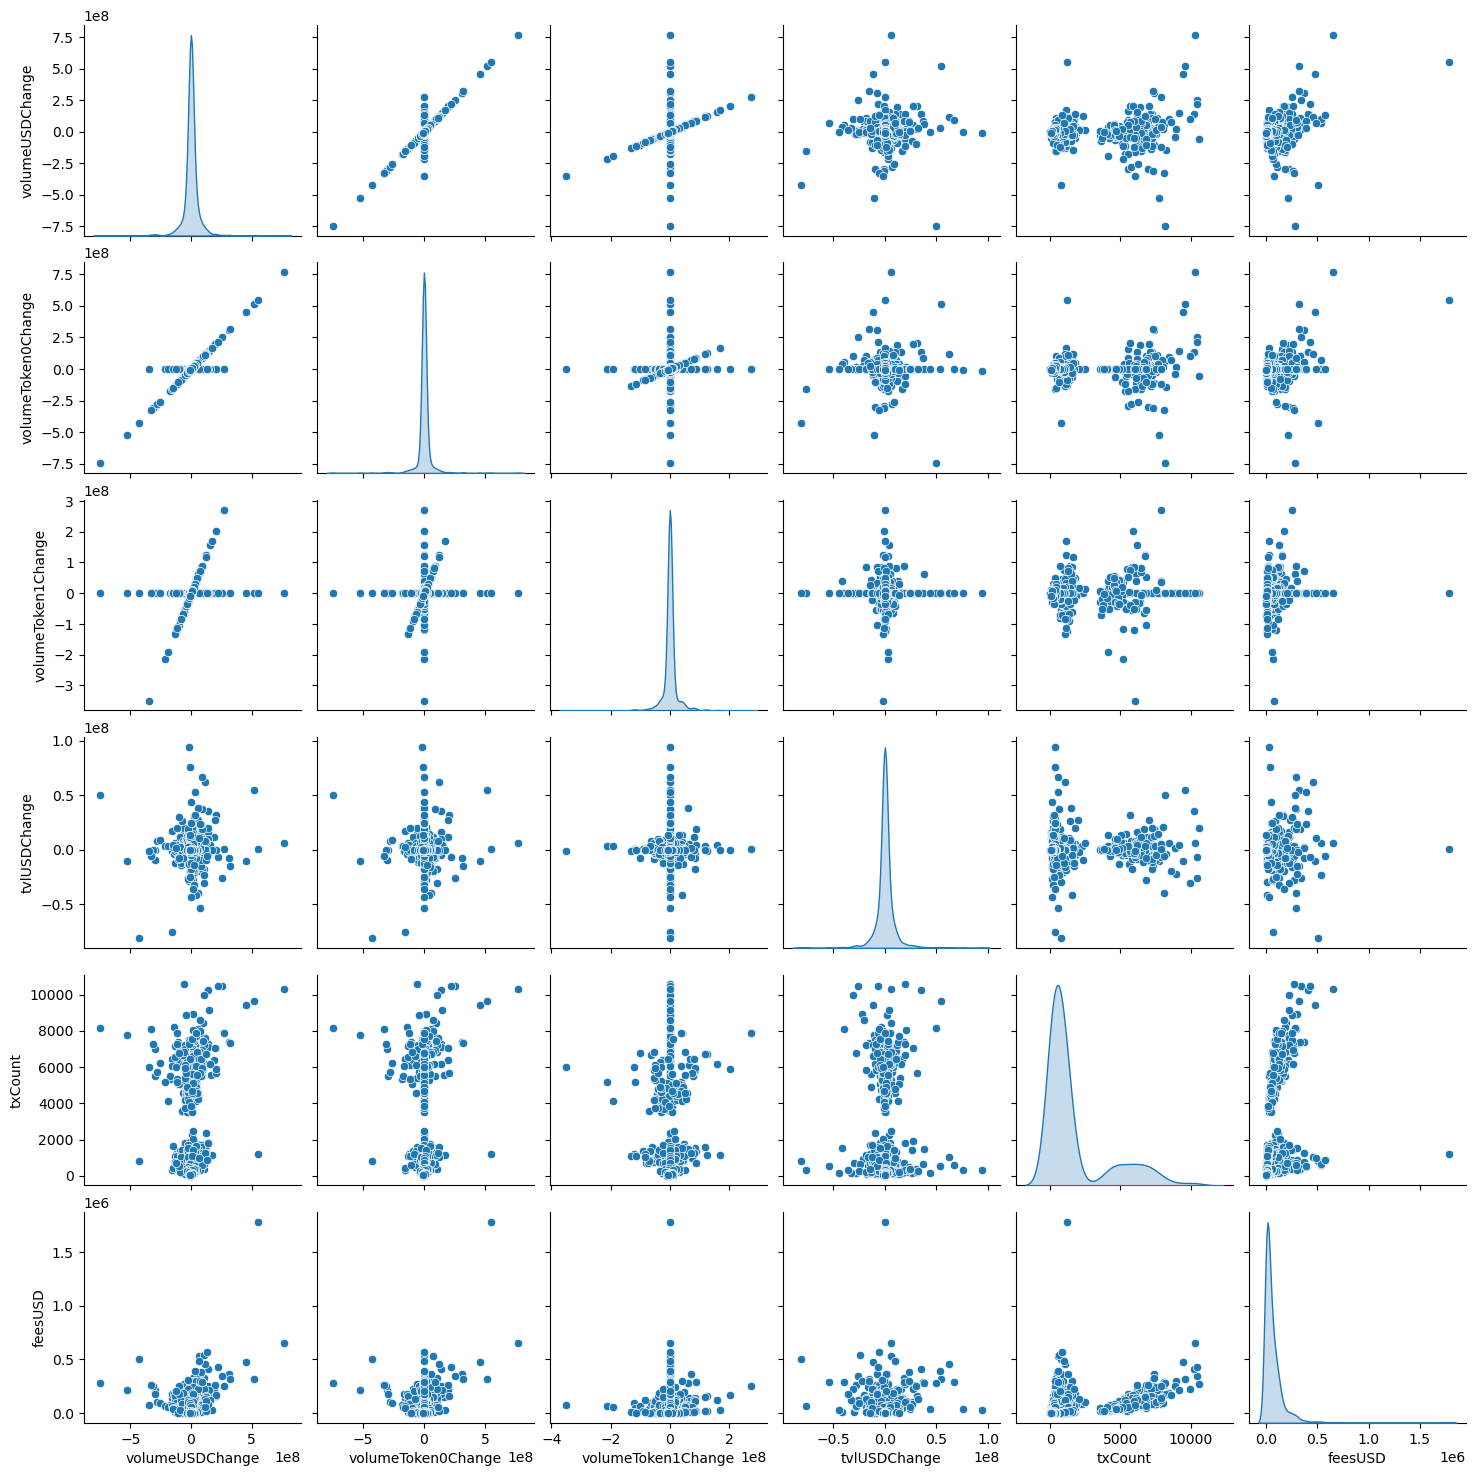

In [5]:
sns.pairplot(pool_data,kind='scatter',diag_kind='kde')

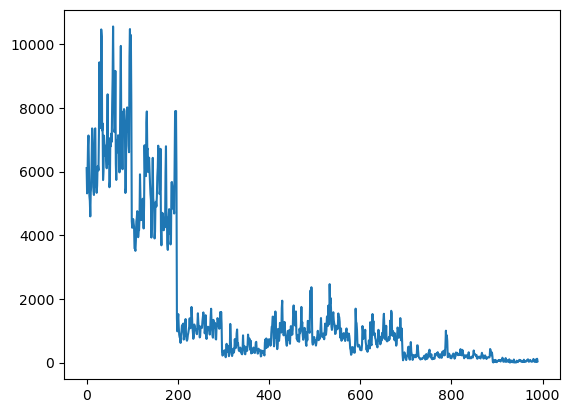

In [6]:
plt.plot(pool_data.index,pool_data[['txCount']],)

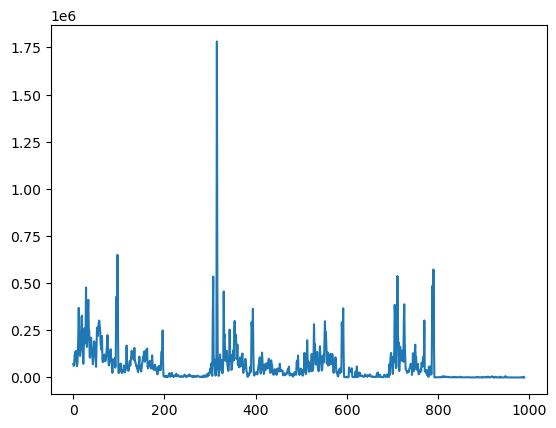

In [7]:
plt.plot(pool_data.index,pool_data[['feesUSD']],)

<Axes: >

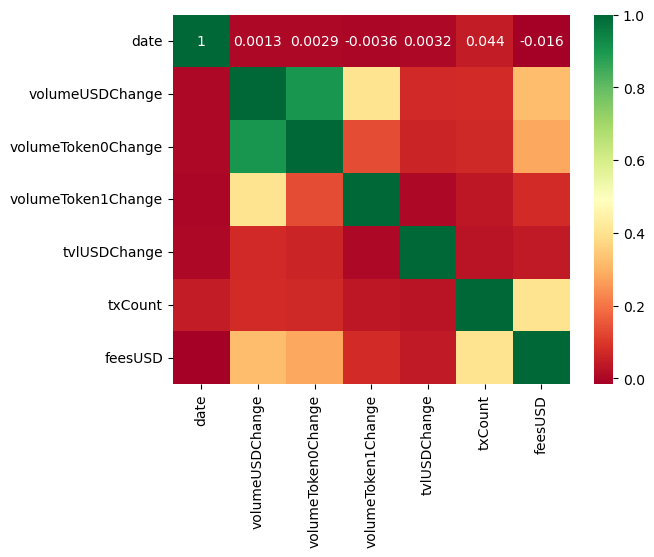

In [8]:
sns.heatmap(pool_data.corr(),cmap="RdYlGn",annot=True)

In [9]:
# initialize scalers
scaler_in = MinMaxScaler()
scaler_out = MinMaxScaler()
# drop the date axis
df_in = pool_data.drop('date',axis=1)
df_out = df_in[['txCount','feesUSD']]


In [10]:
def get_y(data_in):
    # Create an empty DataFrame with the same columns as data_in for the output
    df_out = pd.DataFrame(columns=['txCount', 'feesUSD'])

    # Loop through each row in the input DataFrame except the last one
    for i in range(len(data_in) - 1):
        # Append the next row's 'txCount' and 'feesUSD' as the current row's label
        next_row = data_in.loc[i + 1, ['txCount', 'feesUSD']]
        df_out = pd.concat([df_out, pd.DataFrame([next_row])], ignore_index=True)

    return df_out  

In [11]:
df_out = get_y(df_in)
# Drop the last row of the df_in to make it match the df_out
df_in.drop(index=df_in.index[-1], inplace=True)

/var/folders/1d/bsb5054s6jqfmkmqs04j7lmh0000gn/T/ipykernel_7203/1204670628.py:9: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_out = pd.concat([df_out, pd.DataFrame([next_row])], ignore_index=True)


In [12]:
df_in

,volumeUSDChange,volumeToken0Change,volumeToken1Change,tvlUSDChange,txCount,feesUSD
0,-1.134062e+08,-1.134397e+08,-4.044429e+04,-1.340651e+06,6112,71218.096220
1,-2.021456e+07,-2.022691e+07,-6.543766e+03,2.032085e+06,5318,61110.814054
2,1.004206e+07,1.007014e+07,2.807138e+03,3.506131e+06,5947,66131.846264
3,1.042544e+08,1.042212e+08,3.427840e+04,1.366455e+06,6827,118259.065975
4,3.163059e+07,3.164884e+07,9.927221e+03,5.582752e+06,7136,134074.363181
...,...,...,...,...,...,...
984,6.418975e+04,6.421458e+04,6.425563e+04,2.895587e+02,28,289.730858
985,3.969504e+06,3.970844e+06,3.968074e+06,3.176674e+03,97,2274.482914
986,-2.357123e+06,-2.358593e+06,-2.355664e+06,1.937868e+02,103,1095.921267
987,-1.563509e+06,-1.563453e+06,-1.563555e+06,3.198405e+02,22,314.166828


In [13]:
df_out

,txCount,feesUSD
0,5318.0,61110.814054
1,5947.0,66131.846264
2,6827.0,118259.065975
3,7136.0,134074.363181
4,6223.0,133139.600626
...,...,...
984,97.0,2274.482914
985,103.0,1095.921267
986,22.0,314.166828
987,122.0,4074.578178


In [14]:
# scale the data
scaled_df_in = scaler_in.fit_transform(df_in)
scaled_df_out = scaler_out.fit_transform(df_out)

In [15]:
# split the data into training and test
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(
  scaled_df_in,scaled_df_out,random_state=104,shuffle=True  
)

In [16]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

class Perceptron(nn.Module):
    def __init__(self):
        super(Perceptron,self).__init__()
        self.fc1 = nn.Linear(6,6)
        self.fc2 = nn.Linear(6,2)
    
    def forward(self,x):
        x = self.fc1(x)
        x = F.relu(x)
        x= self.fc2(x)
        
        return x 

In [17]:
model = Perceptron()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [18]:
# Prepare the data
x_train_tensor = torch.from_numpy(x_train.astype(np.float32))
y_train_tensor = torch.from_numpy(y_train.astype(np.float32))

# test
x_test_tensor = torch.from_numpy(x_test.astype(np.float32))
y_test_tensor = torch.from_numpy(y_test.astype(np.float32))
x_test_tensor.dtype

torch.float32

In [19]:
# combine the x,y tensors into one dataset
#Training data
train_dataset = torch.utils.data.TensorDataset(x_train_tensor,y_train_tensor)
# Validation data
val_dataset = torch.utils.data.TensorDataset(x_test_tensor,y_test_tensor)

In [20]:
batch_size = 32
epochs = 500

In [21]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size)

In [22]:
device = ("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
# Training loop
for epoch in range(epochs):
    model.train()
    for x_batch, y_batch in train_loader:
        optimizer.zero_grad()
        x_batch = x_batch.to(device)
        y_batch = y_batch.to(device)
        output = model(x_batch)
        # loss = criterion(output, y_train_tensor[train_sampler.indices])
        loss = criterion(output, y_batch)
        loss.backward()
        optimizer.step()
    
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for x_batch, y_batch in val_loader:
            x_batch = x_batch.to(device)
            y_batch = y_batch.to(device)
            output = model(x_batch)
            loss = criterion(output, y_batch)
            val_loss += loss.item()
    
    val_loss /= len(val_loader)
    print(f'Epoch {epoch+1}/{epochs}, Validation Loss: {val_loss:.4f}')

Epoch 1/500, Validation Loss: 0.0762
Epoch 2/500, Validation Loss: 0.0441
Epoch 3/500, Validation Loss: 0.0309
Epoch 4/500, Validation Loss: 0.0254
Epoch 5/500, Validation Loss: 0.0227
Epoch 6/500, Validation Loss: 0.0213
Epoch 7/500, Validation Loss: 0.0202
Epoch 8/500, Validation Loss: 0.0194
Epoch 9/500, Validation Loss: 0.0188
Epoch 10/500, Validation Loss: 0.0181
Epoch 11/500, Validation Loss: 0.0176
Epoch 12/500, Validation Loss: 0.0170
Epoch 13/500, Validation Loss: 0.0165
Epoch 14/500, Validation Loss: 0.0159
Epoch 15/500, Validation Loss: 0.0154
Epoch 16/500, Validation Loss: 0.0148
Epoch 17/500, Validation Loss: 0.0143
Epoch 18/500, Validation Loss: 0.0137
Epoch 19/500, Validation Loss: 0.0132
Epoch 20/500, Validation Loss: 0.0126
Epoch 21/500, Validation Loss: 0.0121
Epoch 22/500, Validation Loss: 0.0115
Epoch 23/500, Validation Loss: 0.0110
Epoch 24/500, Validation Loss: 0.0105
Epoch 25/500, Validation Loss: 0.0100
Epoch 26/500, Validation Loss: 0.0095
Epoch 27/500, Validat

In [23]:
# set the model to evaluation mode
model.eval()
# move the data to gpu
x_test_tensor = x_test_tensor.to(device)
# run the evaluation
y_pred = model(x_test_tensor)
# copy the prediction from cpu to gpu
y_pred = y_pred.cpu().detach().numpy()
# invert the scaler to get the absolute price data
y_test_orig = scaler_out.inverse_transform(y_test)
y_pred_orig = scaler_out.inverse_transform(y_pred)

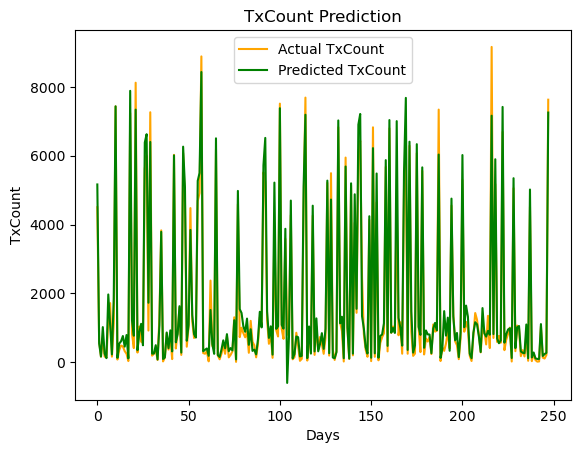

In [24]:
# plots of prediction against actual data
plt.plot(y_test_orig[:,0], label='Actual TxCount', color='orange')
plt.plot(y_pred_orig[:,0], label='Predicted TxCount', color='green')
 
plt.title('TxCount Prediction')
plt.xlabel('Days')
plt.ylabel('TxCount')
plt.legend(loc='best')

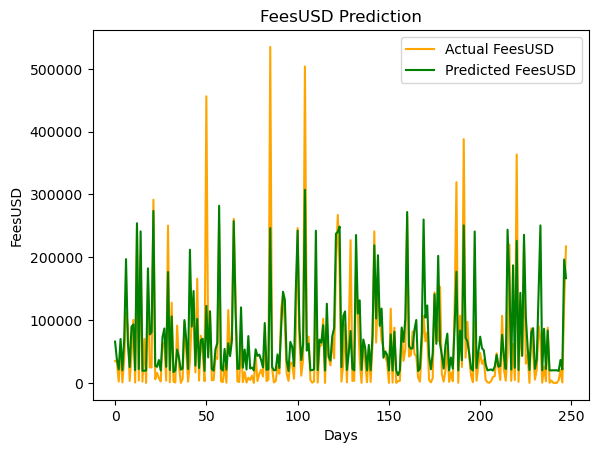

In [25]:
# plots of prediction against actual data
plt.plot(y_test_orig[:,1], label='Actual FeesUSD', color='orange')
plt.plot(y_pred_orig[:,1], label='Predicted FeesUSD', color='green')
 
plt.title('FeesUSD Prediction')
plt.xlabel('Days')
plt.ylabel('FeesUSD')
plt.legend(loc='best')

In [26]:
torch.save(model,'multivariate_linear_model.pth')

In [27]:
import pickle
# save the min max scaler for the models
# Save the scaler parameters to a file
with open('scaler_in.pkl', 'wb') as f:
    pickle.dump(scaler_in, f)

with open('scaler_out.pkl', 'wb') as f:
    pickle.dump(scaler_out, f)

In [30]:
input_size = 6
dummy_input = torch.rand(1,input_size)
input_names = ["input"]
output_names = ["output"]
torch.onnx.export(model,
                 dummy_input,
                 "linear_pool_model.onnx",
                 verbose=False,
                 input_names=input_names,
                 output_names=output_names,
                 export_params=True,
                 )